# An Agentic Graph


We'll define an "agentic" workflow as a graph where a large language model is used to make decisions during the execution of the graph.

These decisions could be:

- Deciding which `node` to visit next
- Deciding which `tools` to use to answer a question (more on this next example!)
- Deciding whether the output of a previous node is correct or not


## Should I go outside today?

Let's construct a graph that helps us decide whether we should venture outside today by checking the weather in a given location, and then using an LLM to categorize if the weather is good or bad.


In [1]:
from IPython.display import Image, display
from pprint import pprint
from typing import Any, Optional, TypedDict
import json
import re
import requests

from langgraph.graph import (
    StateGraph,
    START,
    END,
)  # For creating and running agentic workflows
from rich.console import Console  # For nice printing of Markdown
from rich.markdown import Markdown


def query_llm(prompt: str) -> str:

    url = "http://localhost:11434/api/generate"
    headers = {"Content-Type": "application/json"}
    data = {"model": "llama3.1", "prompt": prompt, "stream": False}

    response = requests.post(url, headers=headers, data=json.dumps(data))

    response_text = response.text
    data = json.loads(response_text)
    actual_response = data.get("response")

    return actual_response

## 1. Define the **State**

This time, our state will need to "remember" the number we are currently working with:


In [2]:
class State(TypedDict):
    location: str
    weather: Optional[str] = None

## 2. Define the **Nodes**

- We'll need one node that gets the weather for a given location (by calling an API)
- The second node will use an LLM to decide if the weather is good or bad
- When the weather is good, we'll make a node that tells us to go outside
- When the weather is bad, we'll make a node that suggests us an indoor activity


In [3]:
def get_the_weather(state: State) -> State:
    """
    This node mocks a weather API by setting the weather based on the location.
    """

    if state.get("location") == "Exeter":
        state["weather"] = "sunny"
    elif state.get("location") == "Glasgow":
        state["weather"] = "rainy"

    return state


def decide_if_weather_is_good(state: State) -> Any:
    """
    This node uses a language model to decide if the weather is good.
    """

    weather = state.get("weather")

    answer = query_llm(
        f"Would the typical person consider {weather} good weather? Answer with yes or no."
    )

    sanitized_answer = re.sub(r"[^a-zA-Z0-9]", "", answer.lower())

    if sanitized_answer == "yes":
        return "tell_me_to_go_outside"
    else:
        return "suggest_an_indoor_activity"


def tell_me_to_go_outside(state: State) -> State:
    """
    This node tells the user to go outside.
    """

    print("You should go touch grass. The weather is good!")

    return state


def suggest_an_indoor_activity(state: State) -> State:
    """
    This node suggests an indoor activity based on the location and weather.
    """

    location = state.get("location")
    weather = state.get("weather")

    suggestion = query_llm(
        f"Can you suggest an indoor activity for someone in {location} when the weather is {weather}?"
    )

    markdown = Markdown(suggestion)
    console = Console()
    console.print(markdown)

    return state

## 3. Build the **Graph**

We'll create a graph that will:

1. Check the weather
2. Use an LLM to decide if the weather is good or bad
3. If the weather is good, suggest going outside, otherwise suggest an indoor activity


In [4]:
# 1. Create a graph
builder = StateGraph(State)

# 2. Add our nodes
builder.add_node("get_the_weather", get_the_weather)
builder.add_node("is_the_weather_good", decide_if_weather_is_good)
builder.add_node("tell_me_to_go_outside", tell_me_to_go_outside)
builder.add_node("suggest_an_indoor_activity", suggest_an_indoor_activity)

# 3. Add edges between nodes
builder.add_edge(START, "get_the_weather")
builder.add_conditional_edges("get_the_weather", decide_if_weather_is_good)
builder.add_edge("tell_me_to_go_outside", END)
builder.add_edge("suggest_an_indoor_activity", END)

# 4. Compile the graph
graph = builder.compile()

`LangGraph` provides a nice method of visualizing the graph, which we can use to check our work:


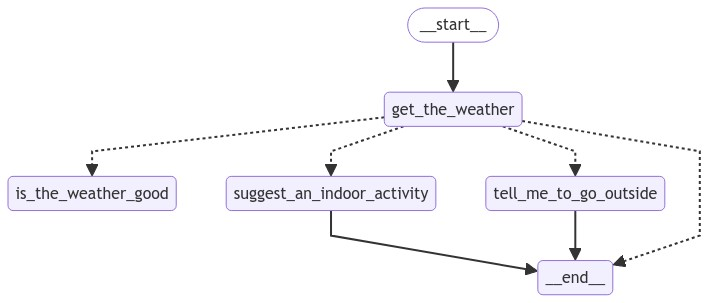

In [5]:
display(Image(graph.get_graph().draw_mermaid_png()))

## 4. Run the **Graph**

Now the exciting part! Let's execute our graph and see what happens:


In [8]:
initial_state = {"location": "Exeter"}

final_state = graph.invoke(initial_state)

You should go touch grass. The weather is good!


In [7]:
pprint(final_state)

{'location': 'Glasgow', 'weather': 'rainy'}
